In [1]:
import requests
import pyobo
from langchain_ollama import chat_models, ChatOllama,OllamaEmbeddings
from langchain.agents.middleware import dynamic_prompt,wrap_model_call,wrap_model_call,ModelRequest,ModelResponse,SummarizationMiddleware
import scispacy
import spacy
import base64
from pydantic import BaseModel, Field
import faiss
import networkx as nx
from typing import Dict, List
import numpy as np
from lxml import html
import pickle
from Bio.UniProt import GOA
from collections import defaultdict
import pandas as pd
from PIL import Image, ImageOps, ImageFilter
import pytesseract
from io import BytesIO
import os
from langchain.messages import HumanMessage, AIMessage, SystemMessage
from langchain.agents import create_agent,AgentState
from langgraph.checkpoint.memory import InMemorySaver
from typing import List,Literal,Optional
from lxml import etree as ET 
import pickle
from langchain.tools import tool
from langchain_community.document_loaders import WebBaseLoader
from bs4 import BeautifulSoup
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
import re
from langchain_text_splitters import RecursiveCharacterTextSplitter
import cv2

/home/bionik/miniconda3/envs/LLM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


In [ ]:
#linker = pyobo.get_scispacy_entity_linker("uniprot", filter_for_definitions=False, resolve_abbreviations=True)
nlp = spacy.load('en_ner_jnlpba_md')
nlp.add_pipe("sentencizer")
linker = pyobo.get_scispacy_entity_linker("hgnc", filter_for_definitions=False, resolve_abbreviations=True)


In [9]:
def pubmed_query(
    include_topics: List[str],
    operator: Literal["AND", "OR"] = "AND",
    exclude_topics: Optional[List[str]] = None,
    publication_type: Optional[Literal["review", "article"]] = None,
    organism: Optional[str] = None,
    journal: Optional[str] = None,
    start_year: Optional[int] = None,
    end_year: Optional[int] = None,
    free_full_text: bool = True
) -> str:
    """
    Build a simple, elegant PubMed query.
    """

    clauses = []

    # Automatic free full text
    if free_full_text:
        clauses.append("free full text[filter]")

    # Include topics
    if include_topics:
        topic_clause = " AND ".join([f'"{t}"[Title/Abstract]' for t in include_topics])
        if len(include_topics) > 1:
            topic_clause = f'({topic_clause})'
        clauses.append(topic_clause)

    # Publication type
    if publication_type:
        pt_map = {"review": "review[Publication Type]", "article": "journal article[Publication Type]"}
        clauses.append(pt_map.get(publication_type.lower(), ""))

    # Organism
    if organism:
        org_map = {"human": "humans[MeSH Terms]", "mouse": "mice[MeSH Terms]", "rat": "rats[MeSH Terms]"}
        clauses.append(org_map.get(organism.lower(), f'"{organism}"[MeSH Terms]'))

    # Journal
    if journal:
        clauses.append(f'"{journal}"[Journal]')

    # Date range
    if start_year and end_year:
        clauses.append(f'("{start_year}"[Date - Publication] : "{end_year}"[Date - Publication])')
    elif start_year:
        clauses.append(f'"{start_year}"[Date - Publication]')
    elif end_year:
        clauses.append(f'"{end_year}"[Date - Publication]')

    # Exclude topics
    if exclude_topics:
        for t in exclude_topics:
            clauses.append(f'NOT "{t}"[Title/Abstract]')

    # Combine clauses with AND
    return " AND ".join(clauses)


In [20]:
query = pubmed_query(
    include_topics=['PI3K-AKT signalling'], # "" activates automatic term mapping
    publication_type="article", # or article or review
    organism="Human",
    start_year=2025,
    end_year=2026
)
query

'free full text[filter] AND "PI3K-AKT signalling"[Title/Abstract] AND journal article[Publication Type] AND humans[MeSH Terms] AND ("2025"[Date - Publication] : "2026"[Date - Publication])'

In [21]:
def fetch_ncbi_data(query):
    base_url_esearch='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi'
    params_esearch = {"db": "pubmed","term": query,"retmode": "json","retstart": 0,"retmax": 10000,'email':'your_email@example.com',
              'datetype':'pdat'}
    response_esearch=requests.get(base_url_esearch, params=params_esearch)
    list_of_pubmed=response_esearch.json()['esearchresult']['idlist']
    print(f"There are total :{len(list_of_pubmed)} Publications")
    dois=[]
    journal=[]
    pmcids=[]
    base_pmc = 'https://www.ncbi.nlm.nih.gov/pmc/articles/'
    base_url_efetch='https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi'
    for list in [list_of_pubmed[i:i+10]for i in range(0,len(list_of_pubmed),10)]:
        param_efetch={'retmode':'xml',"db": "pubmed","id": ','.join(list),"retstart": 0,"retmax": 1000}
        response_efetch=requests.get(base_url_efetch,params=param_efetch)
        tree = ET.fromstring(response_efetch.text)
        base='https://doi.org/'
        for i in tree.findall('PubmedArticle/PubmedData/ArticleIdList/ArticleId'):
            if i.attrib.get('IdType')=='doi':
                dois.append(base+i.text)
            elif i.attrib.get('IdType') == 'pmc':   # ✅ added
                pmcids.append(base_pmc + i.text)
        for i in tree.findall('PubmedArticle/MedlineCitation/Article/Journal/Title'):
            journal.append(i.text)
            
    return dois, journal,pmcids
            

In [22]:
dois, journal,pmcids=fetch_ncbi_data(query)

There are total :53 Publications


In [ ]:
import requests
import re
from bs4 import BeautifulSoup
from typing import Dict, List

def load_pmc_xml(url: str) -> BeautifulSoup:
    if not url.endswith("/"):
        url += "/"

    headers = {
        "User-Agent": 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'
    }

    resp = requests.get(url + "?page=xml", headers=headers, timeout=30)
    resp.raise_for_status()

    return BeautifulSoup(resp.text, "lxml")

def extract_title(soup: BeautifulSoup) -> str:
    h1 = soup.find("h1")
    return h1.get_text(strip=True) if h1 else ""


def extract_abstract(soup: BeautifulSoup) -> str:
    abstract = soup.find("section", class_="abstract")
    if not abstract:
        return ""
    return abstract.get_text("\n", strip=True)

def extract_keyword(soup:BeautifulSoup) -> str:
    keywords=soup.find("section", class_="kwd-group")
    keywords=keywords.get_text()
    text=re.sub(r'^\s*keywords\s*:\s*', '', keywords, flags=re.IGNORECASE)
    text = [kw.strip() for kw in text.split(",") if kw.strip()]
    return text

def extract_h2_sections(soup: BeautifulSoup) -> Dict[str, str]:
    sections = {}

    body = soup.find("section", class_="body")
    if not body:
        return sections

    stop_headers = re.compile(
        r"(acknowledg|author|contribution|Abbreviations|Data sharing statement|conflict|Declaration of interests|footnote|supplement|reference|Contributors)",
        re.I
    )

    current_header = None
    buffer = []

    def flush():
        nonlocal buffer, current_header
        if current_header and buffer:
            sections[current_header] = "\n".join(buffer).strip()
        buffer = []

    # 🔑 WALK *DESCENDANTS* — NOT CHILDREN
    for elem in body.descendants:
        if not getattr(elem, "name", None):
            continue

        # -----------------
        # NEW SECTION
        # -----------------
        if elem.name == "h2":
            header_text = elem.get_text(strip=True)

            if stop_headers.search(header_text):
                flush()
                break

            flush()
            current_header = header_text
            continue

        # -----------------
        # CONTENT
        # -----------------
        if current_header and elem.name in {"p", "div"}:
            text = elem.get_text(" ", strip=True)
            if text:
                buffer.append(text)

    flush()
    return sections


def extract_figures(soup: BeautifulSoup):
    figures = []

    for fig in soup.find_all("figure", class_="fig"):

        fig_id = None
        head = fig.find("h4", class_="obj_head")
        if head:
            fig_id = head.get_text(strip=True)
        else:
            fig_id =fig.get('id')


        img = fig.find("img")
        img_url = img["src"] if img and img.has_attr("src") else None

        caption = fig.find("figcaption")
        caption_text = caption.get_text(" ", strip=True) if caption else None

        figures.append({
            "figure_id": fig_id,
            "image_url": img_url,
            "caption": caption_text
        })

    return figures

def parse_pmc_article(url: str) -> Dict:
    soup = load_pmc_xml(url)

    article = {
        'keywords':extract_keyword(soup),
        'url':url,
        "title": extract_title(soup),
        "sections": {},
        "figures": []
    }
#    abstract = extract_abstract(soup)
#    if abstract:
#        article["sections"]["ABSTRACT"] = abstract

    article["sections"].update(extract_h2_sections(soup))

    article["figures"] = extract_figures(soup)

    return article



In [212]:
import re
from typing import Dict

SECTION_PATTERNS = {
    "Abstract": re.compile(
        r"\b(abstract|summary|research in context)\b", re.I
    ),

    "Introduction": re.compile(
        r"\b(introduction|background|mechanism|pathway|overview|context|rationale|biology)\b",
        re.I,
    ),

    "Methods": re.compile(
        r"\b(methods?|materials?|methodology|experimental|protocols?|procedures?)\b",
        re.I,
    ),

    "Results": re.compile(
        r"\b(results?|findings?|outcomes?|data|analysis|verification|assay|elisa|blot|experiments?)\b",
        re.I,
    ),

    "Discussion": re.compile(
        r"\b(discussion|conclusion|conclusions?|interpretation|implications|future)\b",
        re.I,
    ),
}

def normalize_section_keys(sections: Dict[str, str]) -> Dict[str, str]:
    normalized = {}
    previous_section = None

    for raw_key, content in sections.items():
        key = raw_key.strip()

        # Remove numbering: "1.", "2.3", "IV.", etc.
        key_clean = re.sub(r"^\s*[\dIVXivx.\-–]+?\s*", "", key)
        key_clean = key_clean.lower()

        mapped_section = None
        for canonical, pattern in SECTION_PATTERNS.items():
            if pattern.search(key_clean):
                mapped_section = canonical
                break

        # Inherit previous section if unmatched
        if mapped_section is None:
            mapped_section = previous_section

        # Skip if still None (very first unknown section)
        if mapped_section is None:
            continue

        normalized.setdefault(mapped_section, "")
        normalized[mapped_section] += "\n" + content

        previous_section = mapped_section

    return normalized



In [213]:
all_docs=[]
for i in pmcids: 
    try:
        article = parse_pmc_article(i)
        data=normalize_section_keys(article['sections'])
        article['sections']=data
        if article:
            all_docs.append(article)
    except Exception as e:
        print(e)
        continue



In [87]:
def NLPed(text):
    # ---- HARD SAFETY GUARD ----
    if text is None:
        return "data is not present"

    if not isinstance(text, str):
        return str(text)


    # ---- NLP PROCESSING ----
    doc = nlp(text)
    doc = linker(doc)

    new_text = text
    for ent in reversed(doc.ents):
        kb_ents = ent._.kb_ents
        if kb_ents:
            cui = kb_ents[0][0]
            name = linker.kb.cui_to_entity[cui].canonical_name
            replacement = f"{name} {ent.label_}"
            new_text = (
                new_text[:ent.start_char]
                + replacement
                + new_text[ent.end_char:]
            )

    final_doc = nlp(new_text)
    return " ".join(sent.text.strip() for sent in final_doc.sents)

cleaned_docs = []

for doc in all_docs:
    main = {}

    for key, value in doc.items():
        if key=='url':
            main['url']=value
        
        if key=='keywords':
            main['keywords']=value
            
        if key == "title":
            main["title"] = NLPed(value)

        elif key == "sections" and isinstance(value, dict):
            sections_cleaned = {}
            for sec_key, sec_text in value.items():
                sections_cleaned[sec_key] = NLPed(sec_text)
            main["sections"] = sections_cleaned

        elif key == "figures" and isinstance(value, list):
            figures_cleaned = []
            for fig in value:
                fig_clean = {
                    "figure_id": fig.get("figure_id", "data is not present"),
                    "image_url": fig.get("image_url", "data is not present"),
                    "caption": NLPed(fig.get("caption"))
                }
                figures_cleaned.append(fig_clean)
            main["figures"] = figures_cleaned

    cleaned_docs.append(main)


In [ ]:
class ResearchDocument(Document):
    """
    Custom document for scientific RAG
    """

    def __init__(
        self,
        page_content: str,
        url: str,
        doc_type: str, # title | section | figure | result
        keywords:Optional[List[str]] = None,             
        section_name: Optional[str] = None,
        figure_id: Optional[str] = None,
        image_url: Optional[str] = None,
        caption: Optional[str] = None,
        entities: Optional[List[str]] = None, ## can add entities which are present in the text can be used for filtering
        relations: Optional[List[str]] = None,
        metadata: Optional[Dict] = None,
    ):
        metadata = metadata or {}
        metadata.update({
            "url": url,
            'keywords':keywords,
            "doc_type": doc_type,
            "section_name": section_name,
            "figure_id": figure_id,
            "image_url": image_url,
            "caption": caption,
            "entities": entities or [],
            "relations": relations or []
        })

        super().__init__(
            page_content=page_content,
            metadata=metadata
        )

def build_research_documents(paper):
    docs = []

    # Title
    docs.append(
        ResearchDocument(
            page_content=paper["title"],
            url=paper["url"],
            doc_type="title",
            keywords=paper['keywords']
        ))

    # Sections
    for sec_name, sec_text in paper["sections"].items():
        docs.append(
            ResearchDocument(
                page_content=sec_text,
                url=paper["url"],
                doc_type="section",
                keywords=paper['keywords']
            )
        )

    # Figures
    for fig in paper["figures"]:
        docs.append(
            ResearchDocument(
                page_content=fig["caption"],
                url=paper["url"],
                doc_type="figure",
                figure_id=fig["figure_id"],
                image_url=fig["image_url"],
                caption=fig["caption"],
                keywords=paper['keywords']
            )
        )

    return docs


In [104]:
docs=[]
for i in cleaned_docs:
    doc=build_research_documents(i)
    docs.extend(doc)

In [105]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1024,chunk_overlap=256,length_function=len)
chunks=splitter.split_documents(docs)

In [107]:
embeddings_model = OllamaEmbeddings(model="qwen3-embedding:0.6b",validate_model_on_init=True)
embedding_dim = len(embeddings_model.embed_query("hello world"))
index = faiss.IndexFlatL2(embedding_dim)

vector_store = FAISS(
    embedding_function=embeddings_model,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

In [108]:
ids = vector_store.add_documents(documents=chunks)

In [110]:
vector_store.save_local("/home/bionik/AI_ML/FDA_Project/LLM/faiss_index")

In [ ]:
embeddings_model = OllamaEmbeddings(model="qwen3-embedding:0.6b",validate_model_on_init=True)

vector_store = FAISS.load_local(
    "/home/bionik/AI_ML/FDA_Project/LLM/faiss_index",
    embeddings_model,
    allow_dangerous_deserialization=True 
)

In [245]:
LLM_model = ChatOllama(num_ctx=6000,model="qwen3:4b-instruct-2507-q4_K_M",validate_model_on_init=True)


In [ ]:
'''vector_store.max_marginal_relevance_search(query='Extracellular Vesicles from iPSC-Derived Glial Progenitor',filter={"keywords": 'extracellular vesicles, neuroprotection, glutamate, proteome, transcriptome, glial progenitor cells',
                                                                                                                     'doc_type':'section'},fetch_k=20,k=5)
'''
class RAGMetadataFilter(BaseModel):
    keywords: list[str]
    section_name: List[Literal['Abstract', 'Introduction', 'Methods', 'Results', 'Discussion']]=Field(..., max_items=2)
    doc_type: Literal["review", "article"]
    
prompt="""
You are an expert biomedical research assistant specialized in retrieval-augmented generation (RAG) over NCBI / PMC literature.

Your task is to analyze a user's biomedical research question and generate a
structured metadata filter that will be used to retrieve the most relevant
documents from a research paper database.

Follow these rules strictly:

1. Determine the primary intent of the question. Possible intents include:
   theoretical, experimental, methodological, hypothetical, interpretive, or comparative.

2. Based on the inferred intent, select the most relevant section_name value(s)
   from the following canonical set:
   - abstract
   - introduction
   - methods
   - results
   - discussion

   Use a list only if multiple sections are equally relevant.

3. Select the appropriate doc_type:
   - "review" for conceptual, theoretical, background, or comparative questions
   - "article" for experimental, methodological, or data-driven questions

4. Extract or infer the most relevant biomedical keywords directly from the
   wording of the question. Keywords should be concise and domain-specific.

5. Use lowercase strings for all values.

6. Output ONLY the structured object required by the downstream system.
   Do NOT include explanations, reasoning, comments, or extra text.

Analyze the following user question and return the structured output.

"""

structured_llm = LLM_model.with_structured_output(RAGMetadataFilter)

messages=[
    {"role": "system", "content": prompt},
    {"role": "user", "content": "explain wnt signalling in colon cancer"}
]

result: RAGMetadataFilter = structured_llm.invoke(messages)

In [254]:
{i:v for i,v in result.model_dump().items() if v}

{'keywords': ['wnt signalling', 'colon cancer'], 'doc_type': 'article'}

In [257]:
vector_store.max_marginal_relevance_search(query='wnt signalling',filter={i:v for i,v in result.model_dump().items() if v},fetch_k=20,k=5)


[]

In [ ]:
# =========================================================
# 1️⃣ QUERY CLASSIFICATION (USER OVERRIDE SUPPORTED)
# =========================================================
@dynamic_prompt
def classify_query_middleware(request: ModelRequest) -> str:
    messages = request.state["messages"]
    last_msg = messages[-1]
    original_query = last_msg.content.strip()

    # ✅ CORRECT LOCATION
    user_qtype = None
    if hasattr(last_msg, "additional_kwargs"):
        user_qtype = last_msg.additional_kwargs.get("qtype")

    if user_qtype:
        qtype = user_qtype.strip().upper()
        if qtype not in {"FACTUAL", "REASONING"}:
            raise ValueError(f"Invalid qtype: {qtype}")

        request.state["qtype"] = qtype
        request.state["qtype_source"] = "user"
        request.state["original_query"] = original_query
        return ""

    # ---------- auto classification ----------
    classify_prompt = f"""
Classify the following biomedical question.

Return ONLY one word:
FACTUAL  -> asks for known mechanisms or established facts
REASONING -> asks about consequences, interventions, or what-if scenarios

Question:
"{original_query}"
"""

    qtype = LLM_model.invoke(classify_prompt).content.strip().upper()

    request.state["qtype"] = qtype
    request.state["qtype_source"] = "auto"
    request.state["original_query"] = original_query

    return ""



# =========================================================
# 2️⃣ QUERY REWRITING
# =========================================================
@dynamic_prompt
def rewrite_query_middleware(request: ModelRequest) -> str:
    messages = request.state["messages"]
    original_query = request.state["original_query"]
    qtype = request.state["qtype"]

    history = "\n".join(
        m.content for m in messages[:-1]
        if m.type in {"human", "ai"}
    )

    if qtype == "REASONING":
        rewrite_prompt = f"""
Rewrite the following biomedical question to optimize literature retrieval
for mechanistic reasoning and hypothesis generation.

Rules (STRICT):
- Preserve the scientific intent of the user’s question.
- Treat the question as implicitly referring to the biological context
  established in the conversation history.
- DO NOT add topic of your own in query unless explicitly asked.
- If the question is generic (e.g., "why", "how", "what happens"),
  reinterpret it as applying specifically to the entities, mechanisms,
  or biological systems discussed previously.
- Anchor the rewritten query to the SAME biological focus as the history.
- Do NOT introduce new example entities to illustrate the answer.
- Do NOT broaden to unrelated genes, proteins, pathways, or diseases.
- If generalization is required, restrict it to:
  the same molecular role, functional class, or mechanistic process
  already implied by the context — without naming new entities.
- Prefer standardized biomedical terminology.
- Expand abbreviations where appropriate.
- Do NOT include speculative language in the query itself.
- Return ONLY the rewritten query.

Conversation history:
{history}

Original question:
{original_query}
"""
    else:
        rewrite_prompt = f"""
Rewrite the following biomedical question for precise literature retrieval.

Rules (STRICT):
- Preserve the original meaning exactly.
- Interpret the question in the context of the prior conversation.
- Retain and emphasize the specific biological entities, mechanisms,
  or systems already discussed.
- Do NOT generalize beyond what is explicitly or contextually specified.
- Do NOT introduce new entities.
- Prefer standardized biomedical terminology.
- Expand abbreviations if useful.
- If already optimal, return unchanged.
- Return ONLY the rewritten query.

Conversation history:
{history}

Original question:
{original_query}
"""

    rewritten_query = LLM_model.invoke(rewrite_prompt).content.strip()
    messages[-1].content = rewritten_query
    request.state["rewritten_query"] = rewritten_query

    return ""


# =========================================================
# 3️⃣ RETRIEVAL
# =========================================================
@dynamic_prompt
def retrieve_context_middleware(request: ModelRequest) -> str:
    rewritten_query = request.state["rewritten_query"]

    docs = vector_store.max_marginal_relevance_search(
        rewritten_query,
        k=15,
        fetch_k=30
    )

    sources = "\n\n".join(
        f"[SOURCE {i+1}: {d.metadata.get('source','UNKNOWN')}]\n{d.page_content}"
        for i, d in enumerate(docs)
    )

    request.state["retrieved_context"] = sources
    return ""


# =========================================================
# 4️⃣ DYNAMIC MODEL SELECTION
# =========================================================
@wrap_model_call
def dynamic_model_selection(request: ModelRequest, handler) -> ModelResponse:
    qtype = request.state.get("qtype", "FACTUAL")

    if qtype == "REASONING":
        print("Using REASONING model")
        model = ChatOllama(
            name="reasoning",
            model="qwen3:4b-thinking-2507-q4_K_M",
            num_ctx=10000,
            temperature=0.15,
            reasoning=True,
        )
    else:
        print("Using FACTUAL model")
        model = ChatOllama(
            name="fact",
            model="qwen3:4b-instruct-2507-q4_K_M",
            num_ctx=10000,
            temperature=0.01,
        )

    return handler(request.override(model=model))


# =========================================================
# 5️⃣ FINAL SYSTEM PROMPT (UNCHANGED)
# =========================================================
@dynamic_prompt
def rag_system_prompt(request: ModelRequest) -> str:
    messages = request.state["messages"]
    user_question = messages[-1].content
    history = "\n".join(
        m.content for m in messages[:-1] if m.type in {"human", "ai"}
    )

    context = request.state.get("retrieved_context", "NO_RELEVANT_SOURCES_FOUND")
    qtype = request.state["qtype"]

    if qtype == "FACTUAL":
        mode_instruction = """
FACTUAL MODE (LIFE SCIENCES / HEALTHCARE):

Objective:
Provide a complete, authoritative, evidence-based explanation grounded in
published biomedical literature.

Rules:
- Use retrieved SOURCES as the primary and preferred evidence.
- Describe mechanisms, pathways, molecular interactions, phenotypic effects,
  experimental results, or clinical observations exactly as reported.
- Cover relevant biological detail thoroughly when supported by SOURCES.

General biomedical knowledge:
- May be used ONLY when necessary to complete an explanation.
- Must be explicitly labeled as:
  "General biomedical knowledge (not from retrieved sources):"
- Must be textbook-level, widely accepted, and non-speculative.
- Must not contradict retrieved SOURCES.

Restrictions:
- Do NOT introduce hypotheses, predictions, or inferred outcomes.
- Do NOT generalize beyond what the evidence supports.
- Do NOT add commentary about evidence sufficiency unless explicitly asked.

Citations:
- Every factual claim must be cited.
- Use inline citations as [SOURCE X] with DOI or URL.
"""
    else:
        mode_instruction = """
REASONING MODE (BIOLOGICAL INFERENCE & HYPOTHESIS GENERATION):

Objective:
Generate biologically plausible hypotheses and mechanistic explanations by
connecting patterns across existing biomedical evidence.

Evidence handling:
- Ground all known facts in retrieved SOURCES and cite them as [SOURCE X].
- When direct evidence for the exact query is limited or absent, you MAY:
  - Identify mechanistically analogous, functionally related, or biologically
    comparable evidence present in the SOURCES.
  - Reason across shared biological roles, conserved mechanisms, or similar
    perturbation effects implied by the literature.

Hypothesis construction:
- Hypotheses must be logically derived from cited evidence or established biology.
- Clearly label all inferred or predictive statements as:
  "Hypothesis:"
- Hypotheses must remain biologically consistent and non-contradictory.
- Do NOT present hypotheses as established facts.

General biomedical knowledge:
- May be used to support reasoning when necessary.
- Must be explicitly labeled as:
  "General biomedical knowledge (not from retrieved sources):"

Restrictions:
- Do NOT invent data, mechanisms, or citations.
- Do NOT extrapolate beyond biologically reasonable inference.
- Do NOT introduce unrelated biological domains.

Citations:
- Cite all evidence-based statements and reasoning anchors as [SOURCE X]
  with DOI or URL.
"""

    return f"""
You are a biomedical research assistant.

Global rules:
- Prefer retrieved SOURCES over general knowledge.
- Never invent citations.
- If evidence is insufficient, say so explicitly.
- Provide links to all SOURCES at the end of the answer.

Question:
{user_question}

Conversation history:
{history}

Retrieved sources:
{context}

{mode_instruction}

Produce a structured, citation-grounded answer.
"""


In [ ]:
checkpointer = InMemorySaver()

agent = create_agent(
    model=LLM_model,
    tools=[],
    checkpointer=checkpointer,
    middleware=[
        classify_query_middleware,
        rewrite_query_middleware,
        retrieve_context_middleware,
        dynamic_model_selection,
        rag_system_prompt,
        SummarizationMiddleware(
            model=LLM_model,
            trigger=("tokens", 7000),
            keep=("messages", 10),
        ),
    ],
)

In [ ]:
config: RunnableConfig = {"configurable": {"thread_id": "1"}}

response = agent.invoke({"messages": [{"role": "user",
                "content": "What happens if we added AKT inhibitor to cancer cells?",
                "additional_kwargs": {"qtype": "FACTUAL"}}]},config)

print(response["messages"][-1].content)


Using FACTUAL model
Adding an AKT inhibitor to cancer cells results in the suppression of AKT signaling. Specifically, AKT inhibitors block the activation of AKT by preventing its phosphorylation at key residues—Thr308 and Ser473—required for full activation [SOURCE 11]. This inhibition occurs because AKT activation depends on phosphorylation by upstream kinases such as PDK1 (at Thr308) and mTOR complex 2 (at Ser473) after AKT is recruited to the cell membrane via its PH domain [SOURCE 11].

When an AKT inhibitor is introduced, it directly interferes with the kinase activity of AKT, thereby preventing the phosphorylation of downstream substrates. As a result, the conformational change in AKT that enables its catalytic activity is not achieved, and the signaling cascade that promotes cell survival, proliferation, growth, and metabolism is effectively shut down [SOURCE 11, SOURCE 12].

This suppression of AKT signaling leads to downstream effects such as inhibition of pro-survival pathwa

In [ ]:
response2=agent.invoke({"messages": [{"role": "user",
                "content": "what if we activate it instead of inhibting it?",
                "additional_kwargs": {"qtype": "FACTUAL"}}]},config)
print(response2["messages"][-1].content)


Using FACTUAL model
The effect of activating AKT signaling in cancer cells—instead of inhibiting it—is to promote tumor cell survival, proliferation, growth, and metabolic reprogramming, all of which contribute to cancer progression.

AKT is a serine/threonine kinase that functions as a central mediator of cell survival and growth. When activated, AKT phosphorylates a wide range of downstream targets—including FOXO transcription factors, mTORC1, GSK3, and cell cycle regulators—leading to the inhibition of apoptosis, stimulation of cell cycle progression, and enhancement of metabolic activity [SOURCE 11, SOURCE 6]. This signaling cascade supports uncontrolled cell growth and resistance to cell death, which are hallmarks of cancer.

The PI3K/AKT pathway is one of the most frequently hyperactivated signaling pathways in human cancers. Abnormal overexpression or activation of AKT has been reported in many solid tumors and hematological malignancies and is associated with increased cancer c

In [ ]:
response3=agent.invoke({"messages": [{"role": "user",
                "content": "what if we activate it instead of inhibting it?",
                "additional_kwargs": {"qtype": "REASONING"}}]},config)
print(response3["messages"][-1].content)


Using REASONING model
# Mechanistic Consequences of Activating AKT Signaling in Cancer Cells

The mechanistic consequences of activating AKT signaling in cancer cells involve specific downstream phosphorylation events that ultimately drive pro-survival pathway activation and regulate apoptosis and cell cycle progression.

## Downstream Phosphorylation Events

When AKT is activated in cancer cells, it undergoes specific phosphorylation events that determine its full activation state:

- AKT is first recruited to the plasma membrane via its PH domain
- It undergoes phosphorylation at Thr308 by PDK1 (phosphoinositide-dependent kinase 1)
- Subsequently, it is phosphorylated at Ser473 by mTOR complex 2 (CRTC2 protein), which changes the conformation of AKT and enables its full catalytic activity [SOURCE 11]

Once activated, AKT phosphorylates a wide range of downstream substrates that include:

- **GSK3** (glycogen synthase kinase-3): AKT phosphorylates and inhibits GSK3, which normally reg

In [ ]:
list(agent.get_state(config))

[{'messages': [HumanMessage(content='What is the effect of adding an AKT inhibitor on AKT signaling in cancer cells?', additional_kwargs={'qtype': 'FACTUAL'}, response_metadata={}, id='6fb4d2b8-ad93-4460-8110-72b218c2c935'),
   AIMessage(content='Adding an AKT inhibitor to cancer cells results in the suppression of AKT signaling. Specifically, AKT inhibitors block the activation of AKT by preventing its phosphorylation at key residues—Thr308 and Ser473—required for full activation [SOURCE 11]. This inhibition occurs because AKT activation depends on phosphorylation by upstream kinases such as PDK1 (at Thr308) and mTOR complex 2 (at Ser473) after AKT is recruited to the cell membrane via its PH domain [SOURCE 11].\n\nWhen an AKT inhibitor is introduced, it directly interferes with the kinase activity of AKT, thereby preventing the phosphorylation of downstream substrates. As a result, the conformational change in AKT that enables its catalytic activity is not achieved, and the signaling

In [ ]:
def search_graph(query_protein):
    associated_protein=[]
    for i in range(1,5):
        list=nx.descendants_at_distance(pathway_G, query_protein, i)
        associated_protein.extend(list)
    protein_nodes = set([node_id for node_id, attributes in pathway_G.nodes(data=True) if attributes.get('label') == 'Protein'])
    associated_protein=protein_nodes.intersection(associated_protein)
    return associated_protein  
   
def get_function(protein):
    n_df=df[df['DB_Object_Symbol']==protein]
    function=n_df.groupby(['Aspect','Qualifier'])['GO_ID_name'].apply(set)
    if 'Biological_process' in function.keys():
        datas=[]
        for i in function['Biological_process'].index:
            values = function[('Biological_process', i)]
            values = [str(v) for v in values if pd.notna(v)]
            data='Function of '+protein+ ' is by ' + i + ' ' + ' , '.join(values)
            datas.append(data)
        return '\n'.join(datas)
    else:
        return f'The function of {protein} is not given'

def get_protein_associated_with_term(query):
    datas=[]
    for i,v in ontology_G.nodes(data=True):
        if query in v.get('definition'):
            da=re.sub(r"\[.*?\]$", "", v.get('definition')).replace('"','')
            prot=df[df['GO_ID']==i]['DB_Object_Symbol'].tolist()
            if prot:
                data=v.get('name')+ ' is  ' +da+ ' It involves these proteins ' + ', '.join(prot)
                datas.append(data)
            else:
                data=v.get('name')+ ' is  ' +da
                datas.append(data)
    return '\n'.join(datas)

#@tool
def search_ontology(Protein):
    """Find the function of protein and proteins having similar function
    Find GO of all those proteins and from graph data find which protein it interacts with"""
    #query_protein=state['query_protein']
    query_protein=Protein
    associated_protein=search_graph(query_protein)
    datas=[]
    for i in associated_protein:
        function=get_function(i)
        path_nodes=nx.shortest_path(pathway_G, source=query_protein, target=i)
        edges=[pathway_G[u][v]['label'] for u, v in zip(path_nodes, path_nodes[1:])]
        data=' '.join([x for pair in zip_longest(path_nodes, edges) for x in pair if x is not None])
        data=data + '\n' + function
        datas.append(data)
    return '\n'.join(datas)
    
    
def search_similar_proteins(protein):
    if protein in names:
        idx=names.index(protein)
        distance,index=vector_store_emb.search(vectors[idx:idx+1],k=20)
        prots=operator.itemgetter(*index[0].tolist())(names)
        return list(prots)
    else:
        return f"{protein} is not reviewed protein"

    




In [330]:
pathway_G=nx.read_graphml('/home/bionik/AI_ML/FDA_Project/LLM/Whole_G_for_agent.graphml')
ontology_G=nx.read_graphml('/home/bionik/AI_ML/FDA_Project/Data/GO_enrichment/definition_GO_ontology.graphml')

df=pd.read_csv('/home/bionik/AI_ML/FDA_Project/Data/all_gens_GO_and_syn.tsv',sep='\t')
prot=df[df['Reviewed']=='reviewed']['Gene Names (primary)'].tolist()

ref={'F': "Molecular_function",'P':'Biological_process','C':'Cellular_location'}
GO_2_name={i: v.get('name') for i,v in ontology_G.nodes(data=True)}
GAF_FIELDS=['DB', 'DB_Object_ID', 'DB_Object_Symbol', 'Qualifier', 'GO_ID', 'DB:Reference', 'Evidence', 'With', 'Aspect', 'DB_Object_Name', 'Synonym', 'DB_Object_Type', 'Taxon_ID', 'Date', 'Assigned_By', 'Annotation_Extension', 'Gene_Product_Form_ID']
df = pd.read_csv('/home/bionik/AI_ML/FDA_Project/Data/GO_enrichment/goa_human.gaf', sep='\t', comment='!',header=None, names=GAF_FIELDS, engine='python')
df=df[df['DB_Object_Symbol'].isin(prot)]
df=df[['DB_Object_Symbol','Qualifier','GO_ID','Aspect']]
df['Aspect']=df['Aspect'].map(ref)
df['GO_ID_name']=df['GO_ID'].map(GO_2_name)

In [574]:
with open('/home/bionik/AI_ML/FDA_Project/Data/New/Protein_embeddings.pkl', 'rb') as file:
    prot_emb = pickle.load(file)
file.close()

for key in list(prot_emb.keys()):
    if key not in prot:
        del prot_emb[key]

In [ ]:
vectors=np.array(list(prot_emb.values()))
names=list(prot_emb.keys())
vector_store_emb = faiss.IndexFlatL2(vectors.shape[1])
vector_store_emb.add(vectors)

In [575]:
prots=search_similar_proteins('AKT1')


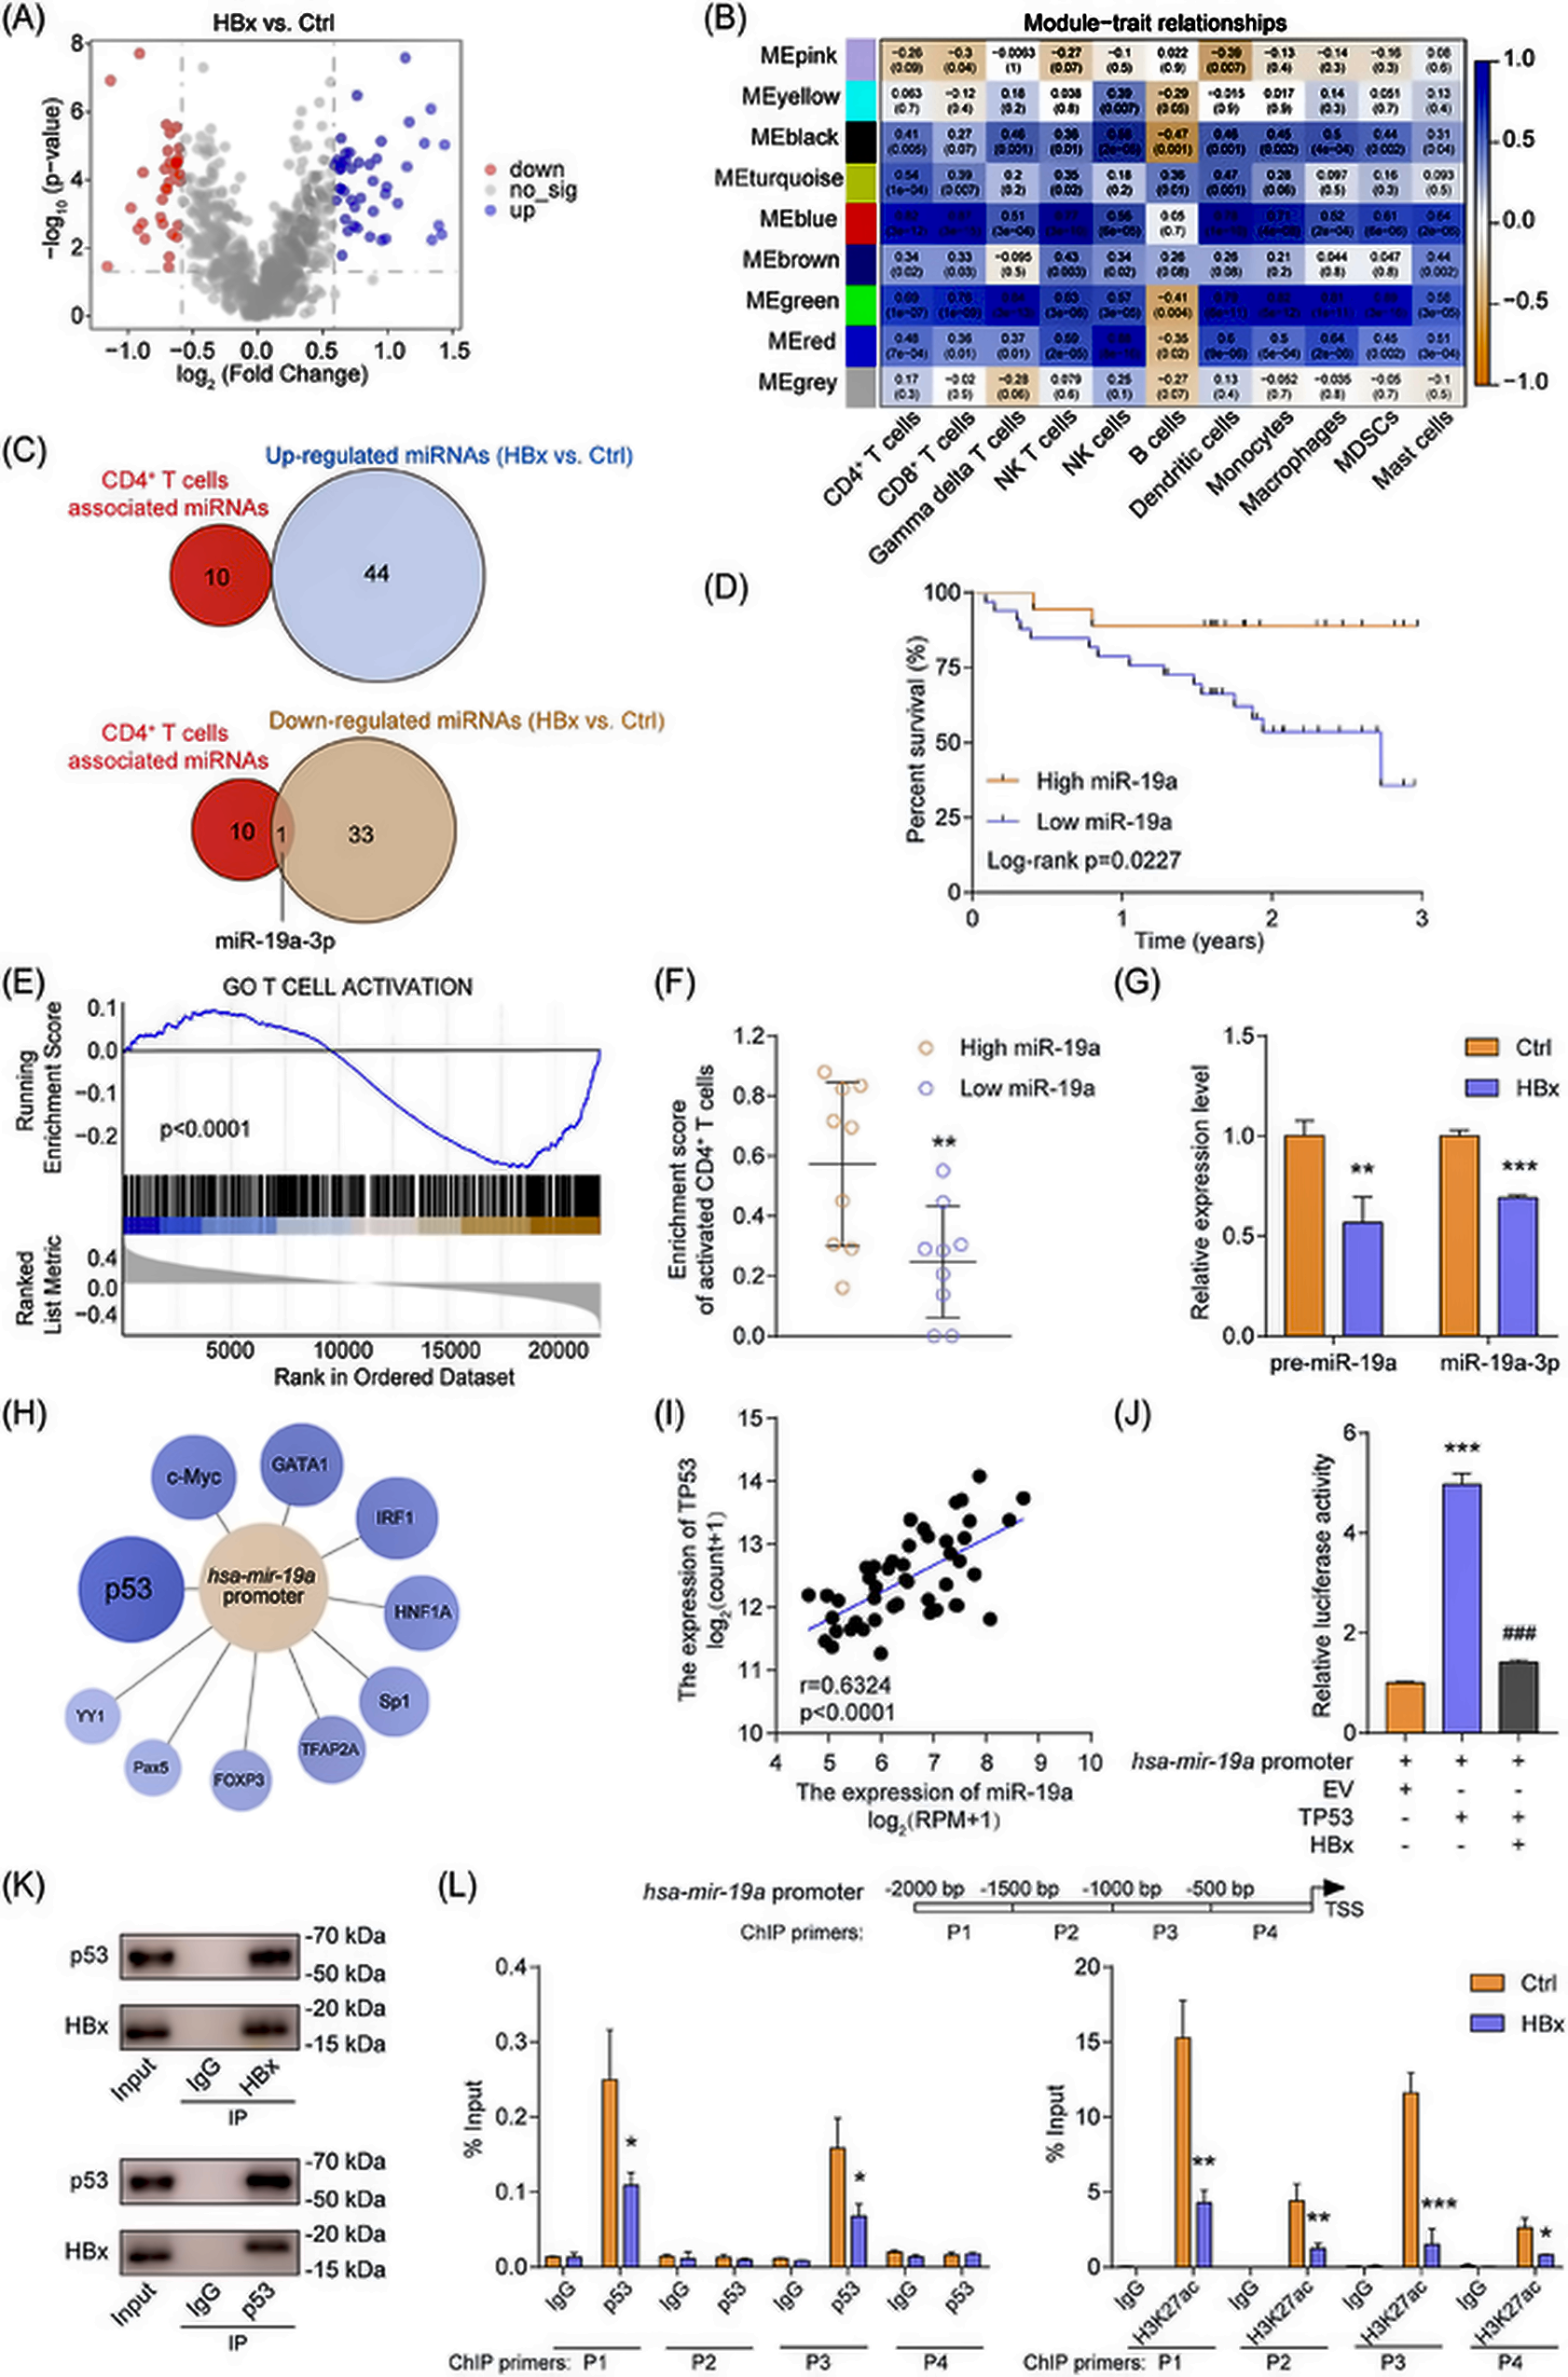

In [ ]:
def fetch_image_bytes(image_url):
    r = requests.get(image_url, stream=True)
    r.raise_for_status()
    return r.content

def enhance_for_vision_models(image_bytes, upscale=2.5):
    # Load image (RGB, lossless)
    pil_img = Image.open(BytesIO(image_bytes)).convert("RGB")
    img = np.array(pil_img)

    h, w = img.shape[:2]
    img = cv2.resize(
        img,
        (int(w * upscale), int(h * upscale)),
        interpolation=cv2.INTER_LANCZOS4
    )

    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(
        clipLimit=2.8,          # lower = safer for plots
        tileGridSize=(8, 8)
    )
    l = clahe.apply(l)

    l_float = l.astype(np.float32)
    shadow_boost = np.clip(
        l_float * 1.05 - 8, 0, 255
    ).astype(np.uint8)

    lab = cv2.merge((shadow_boost, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    blur = cv2.GaussianBlur(img, (0, 0), sigmaX=1.0, sigmaY=1.0)
    img = cv2.addWeighted(
        img, 1.45,    # edge strength
        blur, -0.45,
        0)

    img = cv2.fastNlMeansDenoisingColored(
        img,
        None,
        h=6,
        hColor=4,
        templateWindowSize=7,
        searchWindowSize=21
    )


    p1, p99 = np.percentile(img, (1, 99))
    img = np.clip(
        (img - p1) * 255.0 / (p99 - p1),
        0, 255
    ).astype(np.uint8)

    return img


def detect_panels(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    _, bw = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    bw = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    panels = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w > 300 and h > 300:   # ignore noise
            panels.append((x, y, x + w, y + h))

    # Sort panels top-to-bottom, left-to-right
    panels = sorted(panels, key=lambda b: (b[1], b[0]))
    return panels

def prepare_for_ocr(panel_img):
    gray = cv2.cvtColor(panel_img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    return cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        31, 5
    )


def prepare_image_for_ocr(color_image):
    gray = cv2.cvtColor(color_image, cv2.COLOR_RGB2GRAY)

    # Improve text clarity
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # Adaptive threshold works best for plots + text
    thresh = cv2.adaptiveThreshold(
        gray,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        31,
        5
    )

    return thresh

def ocr_all_orientations(image):
    extracted = []

    for angle in [0,-45,-60,-90]:
        rotated = np.rot90(image, k=angle // 90)


        text = pytesseract.image_to_string(rotated)

        if text.strip():
            extracted.append(f"\n[ROTATION {angle}°]\n{text}")

    return "\n".join(extracted)

def encode_image_base64(image_array):
    success, buffer = cv2.imencode(".png", image_array)
    if not success:
        raise RuntimeError("Encoding failed")
    return base64.b64encode(buffer).decode("utf-8")


def process_figure_in_memory(image_url):
    image_bytes = fetch_image_bytes(image_url)

    # Vision model image
    enhanced_color = enhance_for_vision_models(image_bytes)

    # OCR image (derived from enhanced image)
    ocr_ready = prepare_image_for_ocr(enhanced_color)

    # OCR text
    ocr_text = ocr_all_orientations(ocr_ready)

    # Base64 for display / model ingestion
    image_b64 = encode_image_base64(enhanced_color)

    return enhanced_color, image_b64, ocr_text


def panel_aware_ocr_pipeline(image_url):
    image_bytes = fetch_image_bytes(image_url)

    enhanced = enhance_for_vision_models(image_bytes)
    panel_boxes = detect_panels(enhanced)

    results = []
    panel_labels = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

    for idx, (x1, y1, x2, y2) in enumerate(panel_boxes):
        panel_img = enhanced[y1:y2, x1:x2]

        ocr_ready = prepare_for_ocr(panel_img)
        text = ocr_all_orientations(ocr_ready)

        results.append({
            "panel_id": panel_labels[idx],
            "bbox": (x1, y1, x2, y2),
            "ocr_text": text,
            "image_b64": encode_image_base64(panel_img)
        })

    return {
        "full_image": enhanced,
        "panels": results
    }


image_url = all_docs[0]['figures'][1]['image_url']
enhanced,image_b64 ,text= process_figure_in_memory(image_url)

# Display in Jupyter or Streamlit, for example:
from IPython.display import display, HTML
display(HTML(f'<img src="data:image/png;base64,{image_b64}" width="800">'))

In [57]:
vision_model = ChatOllama(num_ctx=13000,model="granite3.2-vision",validate_model_on_init=True)


In [ ]:
system_extract_prompt_vision = ("""
You are a scientific figure extraction model for NCBI / PubMed Central images.

Your task is to extract ONLY what is explicitly visible in the image.
Do NOT analyze, interpret, infer, summarize, or explain meaning.

Treat the figure as static visual data.

For the full figure:
- Extract the main topic ONLY if written.
- Identify the figure layout and all panel labels exactly as shown.

For EACH panel or sub-panel:
- Extract every visible label, title, axis name, legend entry, protein name, gene name, assay name, condition, and region exactly as written.
- Extract all experimental variables: treatments, time points, controls, inhibitors, doses.
- Extract all quantitative data: numeric values, units, tick labels, percentages.
- Extract visual encodings: colors, bar orientation, symbols, marker types, legend mappings.
- For blots: extract band labels, lane labels, controls.
- For diagrams/networks: extract all node labels and section headers.

Ignore arrows and biological interpretation.
Do NOT infer relationships.
Do NOT fix spelling or fill gaps.

OCR text is provided to recover small, vertical, or rotated labels.
Output must be exhaustive and extraction-only.

""")

messages = [
    SystemMessage(content=system_prompt_vision),
    HumanMessage(content=[{"type": "text", "text": "Analyse this image"},
                          {"type": "image_url","image_url": {"url": f"data:image/jpeg;base64,{image_b64}"}}])]


In [76]:
response = vision_model.invoke(messages)

KeyboardInterrupt: 